# PDF Scraper
##### Yingyi Liang (Aug, 2020)
- Scrape text from PDF using distribution of text, appropriate for PDF which has similar structures each page

In [1]:
#https://stackabuse.com/working-with-pdfs-in-python-reading-and-splitting-pages/
#https://github.com/pymupdf/PyMuPDF
#doc[20].getFontList()

### 0. Imports

In [9]:
import csv
import re
import numpy as np
from numpy.random import default_rng
import pandas as pd
import fitz
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

### 1. Split text data into boxes

In [10]:
#import sample PDF
filename = "directory_1980_drug.pdf"

doc = fitz.open(filename)
print('----- {0} -----\n# of pages:\t{1}\nPage size:\t{2} * {3}'\
      .format(filename, len(doc), doc[0].bound()[2], doc[0].bound()[3]))
if (doc[0].bound()[2] != doc[10].bound()[2]):
    print('Warning: page size not uniform')

----- directory_1980_drug.pdf -----
# of pages:	172
Page size:	615.5999755859375 * 811.2000122070312


In [74]:
YEAR = 1980
#keys
abbr_keys = {'Drug': 'Drug', 'Alcoholism': 'Alcoholism'}
#save dictionary
np.save('keys.npy'.format(YEAR), abbr_keys) 

In [12]:
def find_seps(coords, dist, plot = False):
    '''
    Finds gaps in coords greater than a given dist.
    Inputs:
        coords(list): list of numbers
        dist(int/float): distance between numbers to be considered a gap
        plot(boolean): if True, a histgram of the coordinates and seperation will be plotted
    Returns:
        A list of floats indication seperations.
    '''
    coords.sort()
    coords = np.array(coords)
    seps = (coords[:-1][np.diff(coords) > dist] + coords[1:][np.diff(coords) > dist])/2
    print(seps)
    seps_valid = []
    lb = 0
    for sep in seps:
        if len(coords[(coords > sep) & (coords < sep + 30)]) > 40:
            seps_valid.append(sep)
        lb = sep
    if plot:
        plt.hist(coords, bins = 100)
        for sep in seps_valid:
            plt.axvline(sep, color='black')
    return seps_valid

In [13]:
def find_seps(coords, dist, plot = False):
    '''
    Finds gaps in coords greater than a given dist.
    Inputs:
        coords(list): list of numbers
        dist(int/float): distance between numbers to be considered a gap
        plot(boolean): if True, a histgram of the coordinates and seperation will be plotted
    Returns:
        A list of floats indication seperations.
    '''
    coords.sort()
    coords = np.array(coords)
    seps = coords[1:][np.diff(coords) > dist]
    #print(seps)
    sep1 = []
    sep2 = []
    for sep in seps:
        if len(coords[(coords > sep) & (coords < sep + 20)]) > len(words)/10:
            if (sep > 190 and sep < 235):
                sep1 = [sep - 5]
            if (sep > 370 and sep < 415):
                sep2 = [sep - 5]
    seps_valid = sep1 + sep2
    if plot:
        plt.hist(coords, bins = 100)
        for sep in seps_valid:
            plt.axvline(sep, color='black')
    return seps_valid

In [14]:
# firstpagen = 22
# words = doc[firstpagen - 1].getText("words")
# find_seps([word[0] for word in words], 10, True)

In [15]:
# words = doc[39 - 1].getText("words")
# find_seps([word[0] for word in words], 10, True)

### 2. Organize lines

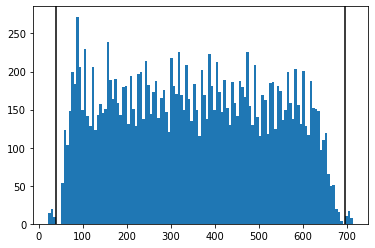

In [16]:
#check page
words = []
for pagen in range(30, 70):
    words += doc[pagen - 1].getText("words")
plt.hist([word[1] for word in words], bins = 120)
plt.axvline(40, color='black')  #cut title
plt.axvline(695, color='black') #cut page number

In [17]:
def split_rows(text, thr):
    '''
    Splits a list of into rows.
    Inputs:
        text: a list of tuple containing individual words and their positions
        thr: the distance between lines
    Outputs:
        List of list that represent rows, arranged by x0 position.
    '''
    if not text:
        return []
    
    text_remain = text
    text_by_row = []
    temp = []
    while len(text_remain) > 0:
        temp_text_remain = []
        y0 = text_remain[0][1]
        i = 0
        while i < len(text_remain):
            if (text_remain[i][1] < y0 + thr) and (text_remain[i][1] > y0 - thr):
                temp.append(text_remain[i])
            else:
                temp_text_remain.append(text_remain[i])
            i += 1
        text_remain = temp_text_remain
        temp.sort(key = lambda x: x[2]) #x[0]
        text_by_row.append(temp)
        temp = []
    text_by_row.sort(key = lambda x: x[0][1])
    return text_by_row

In [18]:
def split_units(col, dist):
    i = 0
    splitted = []
    while i < len(col):
        if i == 0:
            m = sum([word[1] for word in col[i]])/len([word[1] for word in col[i]])
            l = sum([word[1] for word in col[i + 1]])/len([word[1] for word in col[i + 1]])
            if l - m < dist:
                temp = [[word[4] for word in col[i]]]
            else:
                temp = []
        elif i < len(col) - 1:
            u = sum([word[1] for word in col[i - 1]])/len([word[1] for word in col[i - 1]])
            m = sum([word[1] for word in col[i]])/len([word[1] for word in col[i]])
            l = sum([word[1] for word in col[i + 1]])/len([word[1] for word in col[i + 1]])
            if (m - u) > dist and (l - m) > dist and len(temp) > 3:
                pass
            #    splitted.append(temp)
                #temp = []
            elif (m - u) > dist and len(temp) > 3:
                splitted.append(temp)
                temp = [[word[4] for word in col[i]]]
            else:
                temp.append([word[4] for word in col[i]])
        else:
            temp.append([word[4] for word in col[i]])
            splitted.append(temp)
        i += 1
    return [unit for unit in splitted if unit]

In [19]:
firstpagen = 19
data = []
for pagen in range(firstpagen, 168):
    words = doc[pagen - 1].getText("words")
    words = [word for word in words if word[1] > 40 and word[1] < 695]
    seps = find_seps([word[0] for word in words], 10)
    cols = []
    if not seps: #21
        cols.append([word for word in words])
    elif len(seps) == 2: #19
        cols.append([word for word in words if word[0] < seps[0]])
        cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
        cols.append([word for word in words if word[0] > seps[1]])
    else: #20
        cols.append([word for word in words if word[0] < seps[0]])
        cols.append([word for word in words if word[0] > seps[0]])
    #print(cols[0])
    page = []
    for col in cols:
        col = split_rows(col, 5)
        page.append(split_units(col, 10))
    data.append(page)

In [20]:
#data[0][0]

### 3. Write data into csv

- City, state, zip

In [225]:
def is_citystatezip(line):
    if len(line) < 3:
        return False
    line[-2] = line[-2].replace('t1', "H").replace('l', 'I')
    if line[-1].replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5').replace('&', '6').isnumeric()\
    and len(line[-1]) == 5 and line[-2].isupper() and len(line[-2]) == 2\
    and (line[-3][-1] == ',' or line[-3][-1] == '•' or line[-3][-1] == '.'):
        return True
    return False

def clean_citystatezip(line):
    line[-2] = line[-2].replace('t1', "H").replace('l', 'I')
    return [' '.join(line[:-2])[:-1], line[-2], line[-1].replace('l', '1').replace('I', '1')\
            .replace('O', '0').replace('S', '5').replace('&', '6')]

In [117]:
# tests = [
#     ['BIRMINGHAM,', 'AL', '35294'],
#     ['ATMORE,', 'AL', '36504']
# ]

# for t in tests:
#     print(is_citystatezip(t))
#     print(clean_citystatezip(t))

- Contact

In [135]:
def is_contact(line):
    line = ''.join(line)
    if len(line) < 12:
        return False
    if line[1:4].replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5').replace('&', '6').isnumeric()\
    and line[5:8].replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5').replace('&', '6').isnumeric()\
    and line[8] == '-':
        return True

def clean_contact(line):
    line = ''.join(line)
    c = '(' + line[1:4].replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5').replace('&', '6')\
    + ')' + line[5:].replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5').replace('&', '6')
    return c

In [119]:
# tests = [
#     ['(2051', '251-2992']
# ]

# for t in tests:
#     print(is_contact(t))
#     print(clean_contact(t))

- Address

In [137]:
address_indicators = ['P.O.', 'P.0.', 'P.O', 'P.0', \
                      'ROAD', 'HIGHWAY', 'ROUTE', 'BUILDING', 'STREET', 'AVENUE', 'SUITE', 'SUITES', 'DRIVE', 'BOULEVARD', 'BLVD', \
                      'ANNEXT', 'STREETS','FLOOR', 'FL', 'BLDG', 'REAR', 'ROOM', 'BASEMENT', 'BUILDING', 'STATION'] ##
def is_address(line):
    if line[0].replace('-', '').replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5').isnumeric() \
    or any(x in line for x in address_indicators):
        return True
    return False

def clean_address(line):
    if line[0].replace('-', '').replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5').isnumeric():
        line[0] = line[0].replace('-', '').replace('l', '1').replace('I', '1').replace('O', '0').replace('S', '5')
    return ' '.join(line)

- Write to csv

In [231]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) < 2:
            print(facil)
        if len(facil) > 2:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]):
                data_holder.append(clean_address(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]):##
                data_holder.append(clean_address(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address3
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]):##
                data_holder.append(clean_address(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(clean_contact(facil[i]))
                i += 1
            else:
                data_holder.append('')
            data_holder.append(facil[-1][0])
            
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [236]:
filename = "{}.csv".format(1980)
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", "Address1", "Address2", "Address3", "City", "State", "ZIP_Code", "Contact", "Keys"])

In [237]:
pagen = 19

for page in data:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        if col != []:
            page_data_holders += clean_col_data(col)
            print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 19......... Finished Col ......... Finished Col ........ Finished Col 
Page: 20........ Finished Col ...... Finished Col 
Page: 21.. Finished Col 
Page: 22......... Finished Col ......... Finished Col ......... Finished Col 
Page: 23.......... Finished Col ......... Finished Col ......... Finished Col 
Page: 24...... Finished Col 
Page: 25........ Finished Col ........ Finished Col ........ Finished Col 
Page: 26........ Finished Col ........ Finished Col . Finished Col 
Page: 27......... Finished Col ......... Finished Col ........ Finished Col 
Page: 28........ Finished Col ......... Finished Col ........ Finished Col 
Page: 29........ Finished Col ........ Finished Col .......... Finished Col 
Page: 30......... Finished Col ........ Finished Col ........ Finished Col 
Page: 31.......... Finished Col ........... Finished Col ........... Finished Col 
Page: 32.......... Finished Col ......... Finished Col ........ Finished Col 
Page: 33.......... Finished Col ......... Finished 

In [238]:
#check error data
#data[117 - 19][0][1]

- Rewrite data in problem pages

In [230]:
data[101 - 19][0][0][2] = ['PATERSON,', 'NJ', '07501']
data[90 - 19][2][2][4] = ['GREENWOOD,', 'MS', '38701']
data[117 - 19][0][1][5] = ['(516)', '781-1911']

In [171]:
data[73 - 19][2][3] = [['WINNFIELD SUBSTANCE ABUSE SERVICES'],
    ['WINNFIELD,', 'LA', '71483'],
 ['1', '318', 'l', '628-2770'],
 ['Alcoholism/Drug', 'Abuse', 'Treatment', 'Unit']]

In [161]:
data[52 - 19][2][-1] = [['VISTA', 'HALL'],
 ['OGEECHEE', 'OUTPATIENT', 'PROGRAM'],
 ['236', 'VISTA', 'CIRCLE'],
 ['P.O.', 'BOX', '694'],
 ['STATESBORO,', 'GA', '30458'],
 ['C', '912', 'l', '764-6129'],
 ['Alcoholism/Drug', 'Abuse', 'Treatment', 'Unit']]

In [190]:
data[43 - 19][0][3][2] = ['MANCHESTER,', 'CT', '06040']
data[37 - 19][0][0][3] = ['SAN', 'RAFAEL,', 'CA', '94901']
data[37 - 19][0][1][2] = ['SAN', 'RAFAEL,', 'CA', '94901']
data[54 - 19][0][2][2] = ['HILO,', 'HI', '96720']
data[57 - 19][1][1][3] = ['CHICAGO,', 'IL', '60627']
data[76 - 19][0][-1][3] = ['ELLICOTT', 'CITY,', 'MD', '21043']
data[78 - 19][2][-1][3] = ['BROCKTON,', 'HA', '02403']

In [127]:
pagen = 40
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [209, 385]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [198]:
pagen = 86
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [200, 385]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [211]:
pagen = 98
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [200, 385]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [166]:
pagen = 73
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [196, 375]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [164]:
pagen = 71
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
# find_seps([word[0] for word in words], 10, True)
seps = [195]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [80]:
data[132 - 19][1][7] = [["U.S. PENITENTIARY"],
    ['LEWISBURG,', 'PA', '17837'],
 ['I', '717', 'l', "523-'1251"],
 ['Drug', 'Abuse', 'Treatment', 'Unit'],
 ['LEWISTOWN']]

In [43]:
data[77 - 19][0][5][3] = ['ROCKVILLE,', 'HD', '208S0']

In [30]:
data[166 - 19][0] = [[['HOGAR', 'CREA-YABUCOA'],
  ['SALIDA', 'BO', 'CAMINO', 'NUEVO'],
  ['P.O.', 'BOX', '713'],
  ['YABUCOA,', 'PR', '00767'],
  ['(809)', '761-', '0715'],
  ['Drug', 'Abuse', 'Treatment', 'Unit']]]

In [31]:
pagen = 77
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
seps = [190, 375]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [32]:
pagen = 96
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [190, 375]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [60]:
pagen = 26
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [230, 425]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [33]:
pagen = 97
words = doc[pagen - 1].getText("words")
words = [word for word in words if word[1] > 40 and word[1] < 695]
#find_seps([word[0] for word in words], 10, True)
seps = [190, 370]
cols = []
cols.append([word for word in words if word[0] < seps[0]])
cols.append([word for word in words if word[0] > seps[0] and word[0] < seps[1]])
cols.append([word for word in words if word[0] > seps[1]])

page = []
for col in cols:
    col = split_rows(col, 5)
    page.append(split_units(col, 10))

data[pagen - 19] = page

In [34]:
data[107 - 19][1][5] = [['CITY', 'OF', 'BUFFALO', 'OHR'],
 ['ELLICOTT/MASTEN', 'COMM', 'COUNSELING', 'CENTER'],
 ['560', '-', '562', 'WILLIAM', 'STREET'],
 ['BUFFALO,', 'NY', '14204'],
 ['I716l', '855-4069'],
 ['Drug', 'Abuse', 'Treatment', 'Unit']]

In [35]:
data[107 - 19][2][2] = [['MENTAL', 'HEALTH', 'SERVICES', 'CORP', 'VI'], ['LOWER', 'WEST', 'SIDE', 'DRUG', 'ABUSE', 'PROGRAM'],
                        ['485', 'NIAGARA', 'STREET'], ['BUFFALO,', 'NY', '14201'],
                       ['I716l', '856-2000'], ['Drug', 'Abuse', 'Treatment', 'Unit']]

In [36]:
data[129 - 19][0][3] = [['HID', 'COLUMBIA', 'CENTER', 'FOR', 'LIVING'],
 ['400', 'EAST', 'FIFTH', 'STREET'],
 ['COURTHOUSE', 'ANNEX', 'A', 'ROOM', '106'],
 ['THE', 'DALLES,', 'OR', '97058'],
 ['(503)', '296-5452'],
 ['Alcoholism/Drug', 'Abuse', 'Treatment', 'Unit']]

data[129 - 19][0][4] = [['TILLAMOOK', 'COUNTY'],
 ['COMM', 'COUNSELING', 'SERVICES', 'DRUG', 'PROGRAM'],
 ['2405', 'FIFTH', 'STREET'],
 ['TILLAMOOK,', 'OR', '97141'],
 ['(503)', '842-8201'],
 ['Drug', 'Abuse', 'Treatment', 'Unit']]

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [243]:
df = pd.read_csv("{}.csv".format(1980))
df

,Name1,Name2,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Keys
0,ALEXANDER CITY WORK RELEASE CENTER,NaN,P.O. BOX 705,NaN,NaN,ALEXANDER CITY,AL,35010.0,(205)234-7533,Drug
1,CALHOUN-CLEDURNE MENTAL HEALTH CENTER,SUBSTANCE ABUSE PROGRAM,331 EAST EIGHTH AVENUE,NaN,NaN,ANNISTON,AL,36202.0,(205)236-3403,Alcoholism/Drug
2,BOARD OF CORRECTIONS DRUG ABUSE,PROGRAM FOR ALABAMA INMATES,313 NORTH MAIN,P.O. BOX 266,NaN,ATMORE,AL,36504.0,(205)368-1675,Drug
3,BESSEMER OUTPATIENT TREATMENT CENTER,NaN,1830 THIRD AVENUE,SUITE 308,NaN,BESSEMER,AL,35020.0,(205)426-8020,Drug
4,ALETHEIA HOUSE INC,NaN,3600 EIGHTH AVENUE SOUTH,SUITE W-110,NaN,BIRMINGHAM,AL,35222.0,(205)324-6502,Drug
...,...,...,...,...,...,...,...,...,...,...
3161,GUAM COMMUNITY MENTAL HEALTH CENTER,DRUG TREATMENT PROGRAM,P.O. BOX AX,NaN,NaN,AGANA,GU,96910.0,(671)646-9378,Alcoholism/Drug
3162,ST CROIX ALCOHOL AND,DRUG DEPENDENCY UNIT,153 RICHMOND,NaN,NaN,"CHRISTIANSTED, SAINT CROIX",VI,820.0,(809)773-5150,Alcoholism/Drug
3163,DEPARTMENT OF HEALTH SERVICES,OFFICE OF THE HIGH COMMISSIONER,NaN,HICOM HDQTRS,NaN,"SAIPAN, MARIANA ISLANDS",TT,96950.0,NaN,Alcoholism/Drug
3164,CATHOLIC SOCIAL SERVICES,NaN,1 S A,BLOCK 2 LOT 5 TRACT 10,NaN,PAGAT BARRIGADA,GU,96910.0,(671)734-3593,Alcoholism/Drug


In [244]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[6])!=2:
        print(index)

In [245]:
#check if all zip codes are correct
df.dtypes

Name1        object
Name2        object
Address1     object
Address2     object
Address3     object
City         object
State        object
ZIP_Code    float64
Contact      object
Keys         object
dtype: object

- Correct in Pandas

In [246]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'AND':
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [247]:
# def split_zip(zipc):
#     if '-' in zipc:
#         return zipc.split('-')
#     return [zipc, None]
# #split zip-code if zip code is in the format xxxxx-xxxx
# df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
# df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [248]:
df.to_csv('{}_c.csv'.format(1980), index = False)